

# 1. Introduction
The ionosphere is the ionized part of Earth's upper atmosphere, from about 48 km 965 km altitude. Our task is to distinguish different type of radar returns to understand if at the time of return ionosphere had some meaningful structure of free electrons. We perform a comprehensive analysis of data at hand and use state-of-the-art Machine learning algorithms to perform the fully supervised classification task. This work can be divided into four sections:
<br>
- Exploratory data analysis
- Preprocessing
- Classification without any data transormation to avoid explainability issues
- Classfication using low-dimensional data transformed by PCA

## 1.1 Dataset Description
This radar data [1][2] was collected by a system in Goose Bay, Labrador. This system consists of a phased array of 16 high-frequency antennas with a total transmitted power on the order of 6.4 kilowatts.  
The targets were free electrons in the ionosphere. "Good" radar returns are those showing evidence of some type of structure in the ionosphere. "Bad" returns are those that do not; their signals pass through the ionosphere.  
<br>
Extreme UltraViolet (EUV) and x-ray solar radiation ionizes the atoms and molecules inside the Ionosphere thus creating a layer of electrons. The ionosphere is important because it reflects and modifies radio waves used for communication and navigation. Other phenomena such as energetic charged particles and cosmic rays also have an ionizing effect and can contribute to the ionosphere. 
<br>
<center>
    <img src="https://media.giphy.com/media/hyr2a0p7JRuLWu1ZKq/giphy.gif" alt="Drawing"  class="center"/>
<br>
<br>
    <img src="https://i.imgur.com/6bwvRCe.png" alt="Drawing"  class="center" style="width: 40%;height: 100%"/>
</center>
<br>

The radar operates by transmitting a multipulse pattern to the ionosphere. It produces 17 pairs of numbers every 0.2 s all year round. Received signals were processed using an autocorrelation function whose arguments are the time of a pulse and the pulse number. There were 17 pulse numbers for the Goose Bay system. Instances in this dataset are described by 2 attributes per pulse number, corresponding to the complex values returned by the function resulting from the complex electromagnetic signal. [1]


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pprint import pprint

pd.set_option("display.precision", 5)
warnings.filterwarnings("ignore")
sns.set(rc={"figure.dpi":100, 'savefig.dpi':300})
%matplotlib inline

In [2]:
def rename(x):
    if 'feature' in x:
        return x.replace("feature", "f")
    return x

file = "/kaggle/input/uci-ionosphere/ionosphere_data_kaggle.csv"

df = pd.read_csv(file)
target_map = {"g" : 1, "b" : 0}
df["label"] = df.label.map(target_map).astype(np.int)
df = df.rename(columns= rename)

# 2 Exploratory Data Analysis
## 2.1 Attribute information

The dataset contains **351** distinct radar returns. Each return produces 17 pairs of complex numbers. Numbers are reported as features and divided into real and imaginary parts giving us a total of **34** features.  
All features are continuous and contain no missing values. **Good** returns are labelled as 1 whereas **Bad** returns are labelled as 0.

### Statistical overview:  
For each feature, we briefly analyze their statistical properties such as mean, standard deviation, minimum, maximum and quartiles. It helps us understand the scale of different features which is a building block of upcoming preprocessing steps.

In [3]:
df.drop("label", axis = 1).describe().T

,count,mean,std,min,25%,50%,75%,max
f1,351.0,0.89174,0.31115,0.0,1.00000,1.00000,1.00000,1.0
f2,351.0,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.0
f3,351.0,0.64134,0.49771,-1.0,0.47213,0.87111,1.00000,1.0
f4,351.0,0.04437,0.44143,-1.0,-0.06474,0.01631,0.19418,1.0
f5,351.0,0.60107,0.51986,-1.0,0.41266,0.80920,1.00000,1.0
f6,351.0,0.11589,0.46081,-1.0,-0.02479,0.02280,0.33466,1.0
f7,351.0,0.55010,0.49265,-1.0,0.21131,0.72873,0.96924,1.0
f8,351.0,0.11936,0.52075,-1.0,-0.05484,0.01471,0.44567,1.0
f9,351.0,0.51185,0.50707,-1.0,0.08711,0.68421,0.95324,1.0
f10,351.0,0.18135,0.48385,-1.0,-0.04807,0.01829,0.53419,1.0


### Data distribution
Since all features are numerical attributes, we plot their distribution with histograms and estimate their kernel density function.


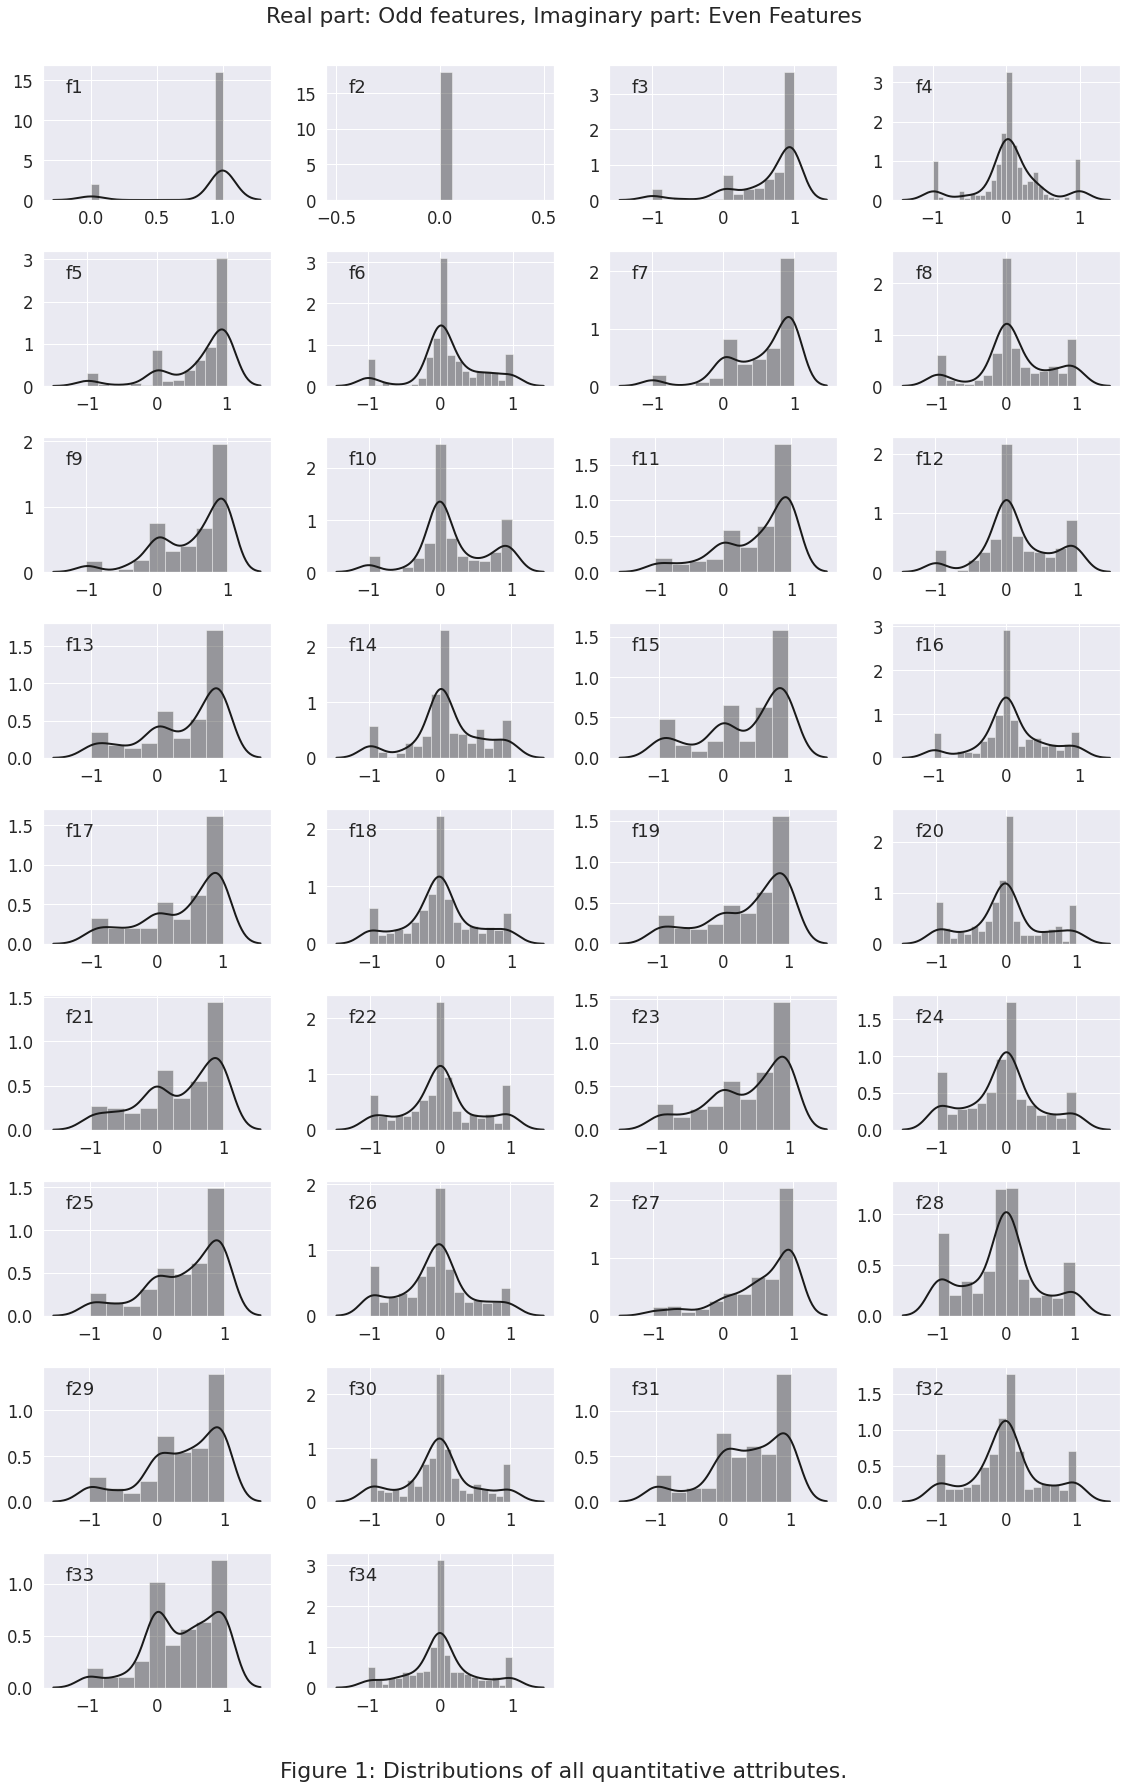

In [4]:
sns.set_style("whitegrid")

num_cols = df.select_dtypes(include= ['Float64', 'int64']).columns
sns.set(font_scale=1.5)
fig, axes = plt.subplots(nrows=9, ncols=4, figsize=(16,24))
fig.delaxes(axes[8,2])
fig.delaxes(axes[8,3])

# fig.subplots_adjust(hspace=0.5)
# fig.suptitle('Distributions of numerical Features', fontsize = 36)


for ax, feats in zip(axes.flatten(), num_cols):
    fig = sns.distplot(a=df[feats], ax=ax, kde_kws={"lw":2}, color="k")
    ax.set_ylabel("")
    ax.text(0.1,0.8, ax.xaxis.get_label().get_text(), transform=ax.transAxes)
    ax.set_xlabel("")
    
plt.figtext(0.5,-0.025,"Figure 1: Distributions of all quantitative attributes.", fontsize = 22, ha = 'center')
plt.gcf().suptitle("Real part: Odd features, Imaginary part: Even Features", y = 1)
plt.tight_layout()
plt.show()

## 2.2 Target class distribution
The distribution of target classes is plotted in figure 2. The dataset is not perfectly balanced as we have one majority class with approximately 64% of instances and one minority class with 36% of total instances.



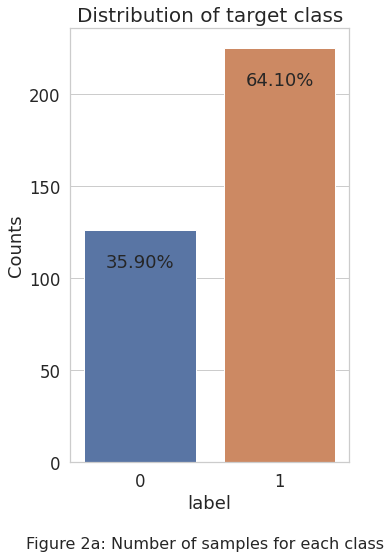

In [5]:
sns.set_style("whitegrid")
plt.figure(figsize = (5,8))
ax = sns.countplot(x='label',data=df, dodge = False)

bars = ax.patches
half = int(len(bars)/2)
left_bars = bars[:half]
right_bars = bars[half:]

for left, right in zip(left_bars, right_bars):
    height_l = left.get_height()
    height_r = right.get_height()
    total = height_l + height_r

    ax.text(left.get_x() + left.get_width()/2., 
            height_l -20, '{0:.2%}'.format(height_l/total), ha="center", fontsize = 18)
    ax.text(right.get_x() + right.get_width()/2., 
            height_r -20, '{0:.2%}'.format(height_r/total), ha="center", fontsize = 18)


plt.xlabel("label")
plt.ylabel("Counts")
plt.title("Distribution of target class", fontsize = 20)
plt.figtext(0.5,-0.025,"Figure 2a: Number of samples for each class", fontsize = 16, ha = 'center')
plt.show()

We look at each feature separatly for each class to find if there exist any feature which can provide better classification.

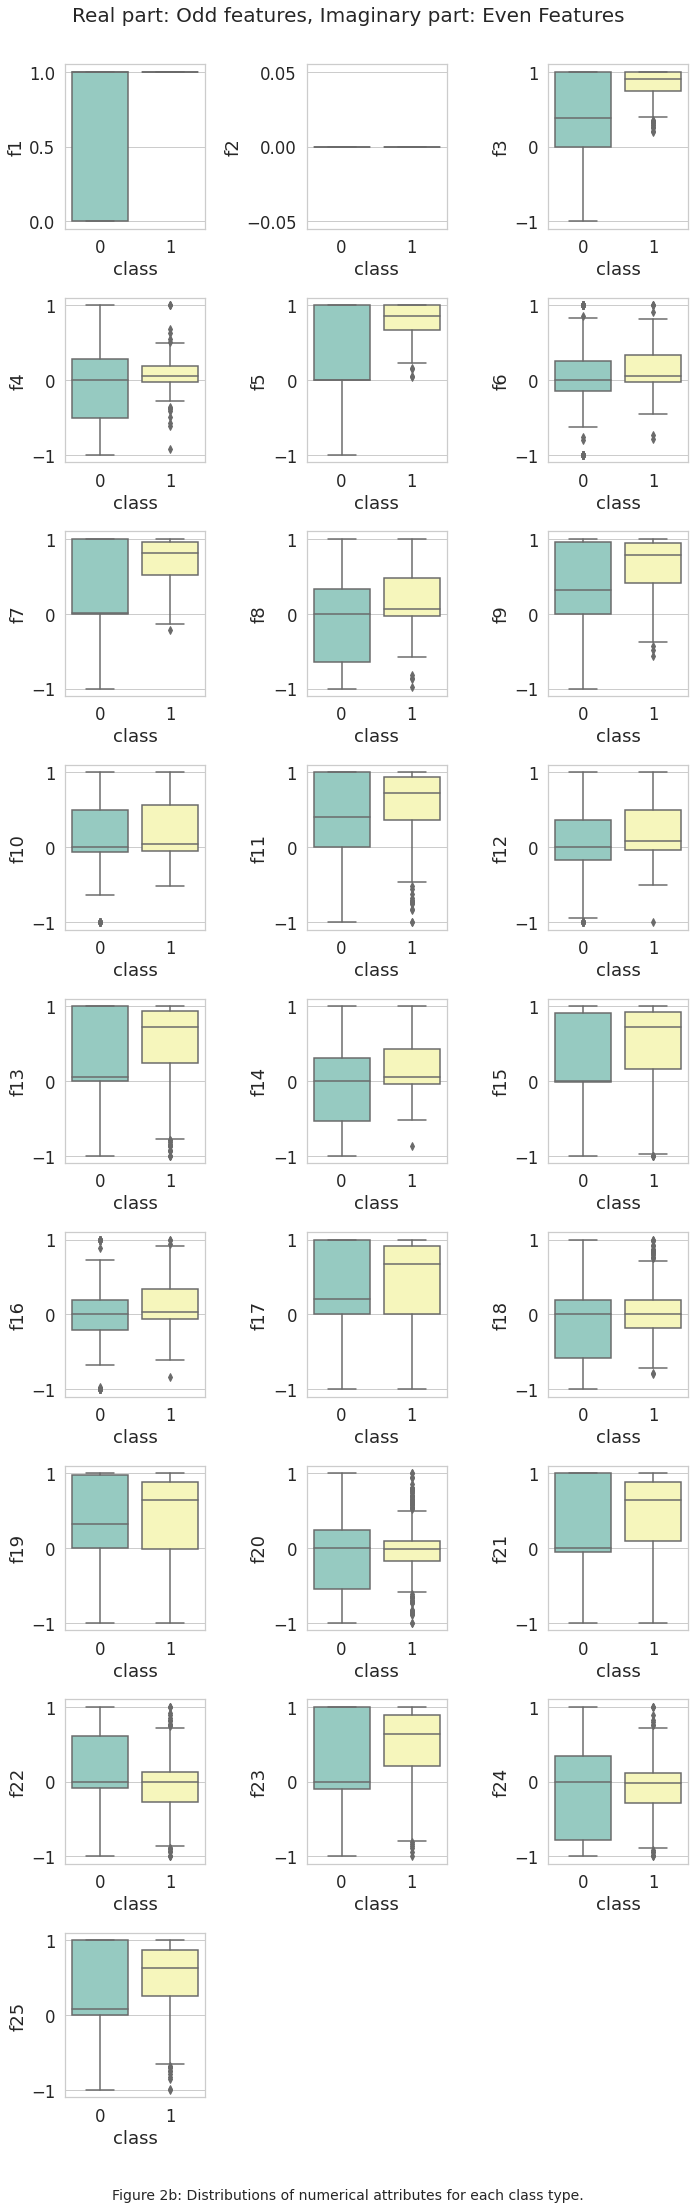

In [6]:
sns.set_style("whitegrid")

fig, axes = plt.subplots(nrows=9, ncols=3, figsize=(10,30))
fig.delaxes(axes[8,1])
fig.delaxes(axes[8,2])

# fig.subplots_adjust(hspace=0.5)
# fig.suptitle('Distributions of numerical Features', fontsize = 36)


for ax, feats in zip(axes.flatten(), num_cols):
    fig = sns.boxplot(y=feats, x = 'label', data=df, palette="Set3", ax = ax)
    ax.set_ylabel(feats)
#     ax.text(0.1,0.8, ax.xaxis.get_label().get_text(), transform=ax.transAxes)
    ax.set_xlabel('class')
    
plt.figtext(0.5,-0.015,"Figure 2b: Distributions of numerical attributes for each class type.", fontsize = 14, ha = 'center')
plt.gcf().suptitle("Real part: Odd features, Imaginary part: Even Features", size = 20, y=1)
plt.tight_layout()
plt.show()

## 2.3 Feature Correlation
A very useful way to analyze the correlation between numerical features is the correlation matrix.  
For each pair of attributes we can compute the covariance and divide it by the product of the standard deviations.
$$
Cov(x,y) = \frac{1}{n-1} \sum \limits _{i = 1} ^{n} (x_i - \mu_x)(y - \mu_y)
$$  

$$
\rho = \frac{Cov(x,y)}{S_x  S_y}
$$
Where $\mu_x$ and $\mu_y$ are sample means of arbitrary x, y features and $S_x$, $S_y$ are their respective standard deviations.  $\rho$ is called the Pearson correlation coefficient and it measures the linear correlation between two sets of data.  $\rho$ is a continuous number in between -1 and 1 (figure 3).  If two random variables are statistically independent, corresponding correlation values are 0. It is important to notice that the opposite is not true, two random variables may show 0 correlation and may yet be completely dependent on each other. This is due to the fact that $\rho$ measures only "linear" correlation and predictors may have non linear dependencies. 

<figure>
  <center>
  <img src="https://i.imgur.com/g7L9k6f.png" alt="Drawing" style="width: 800px;height: 300px"/>
    </center>
</figure>


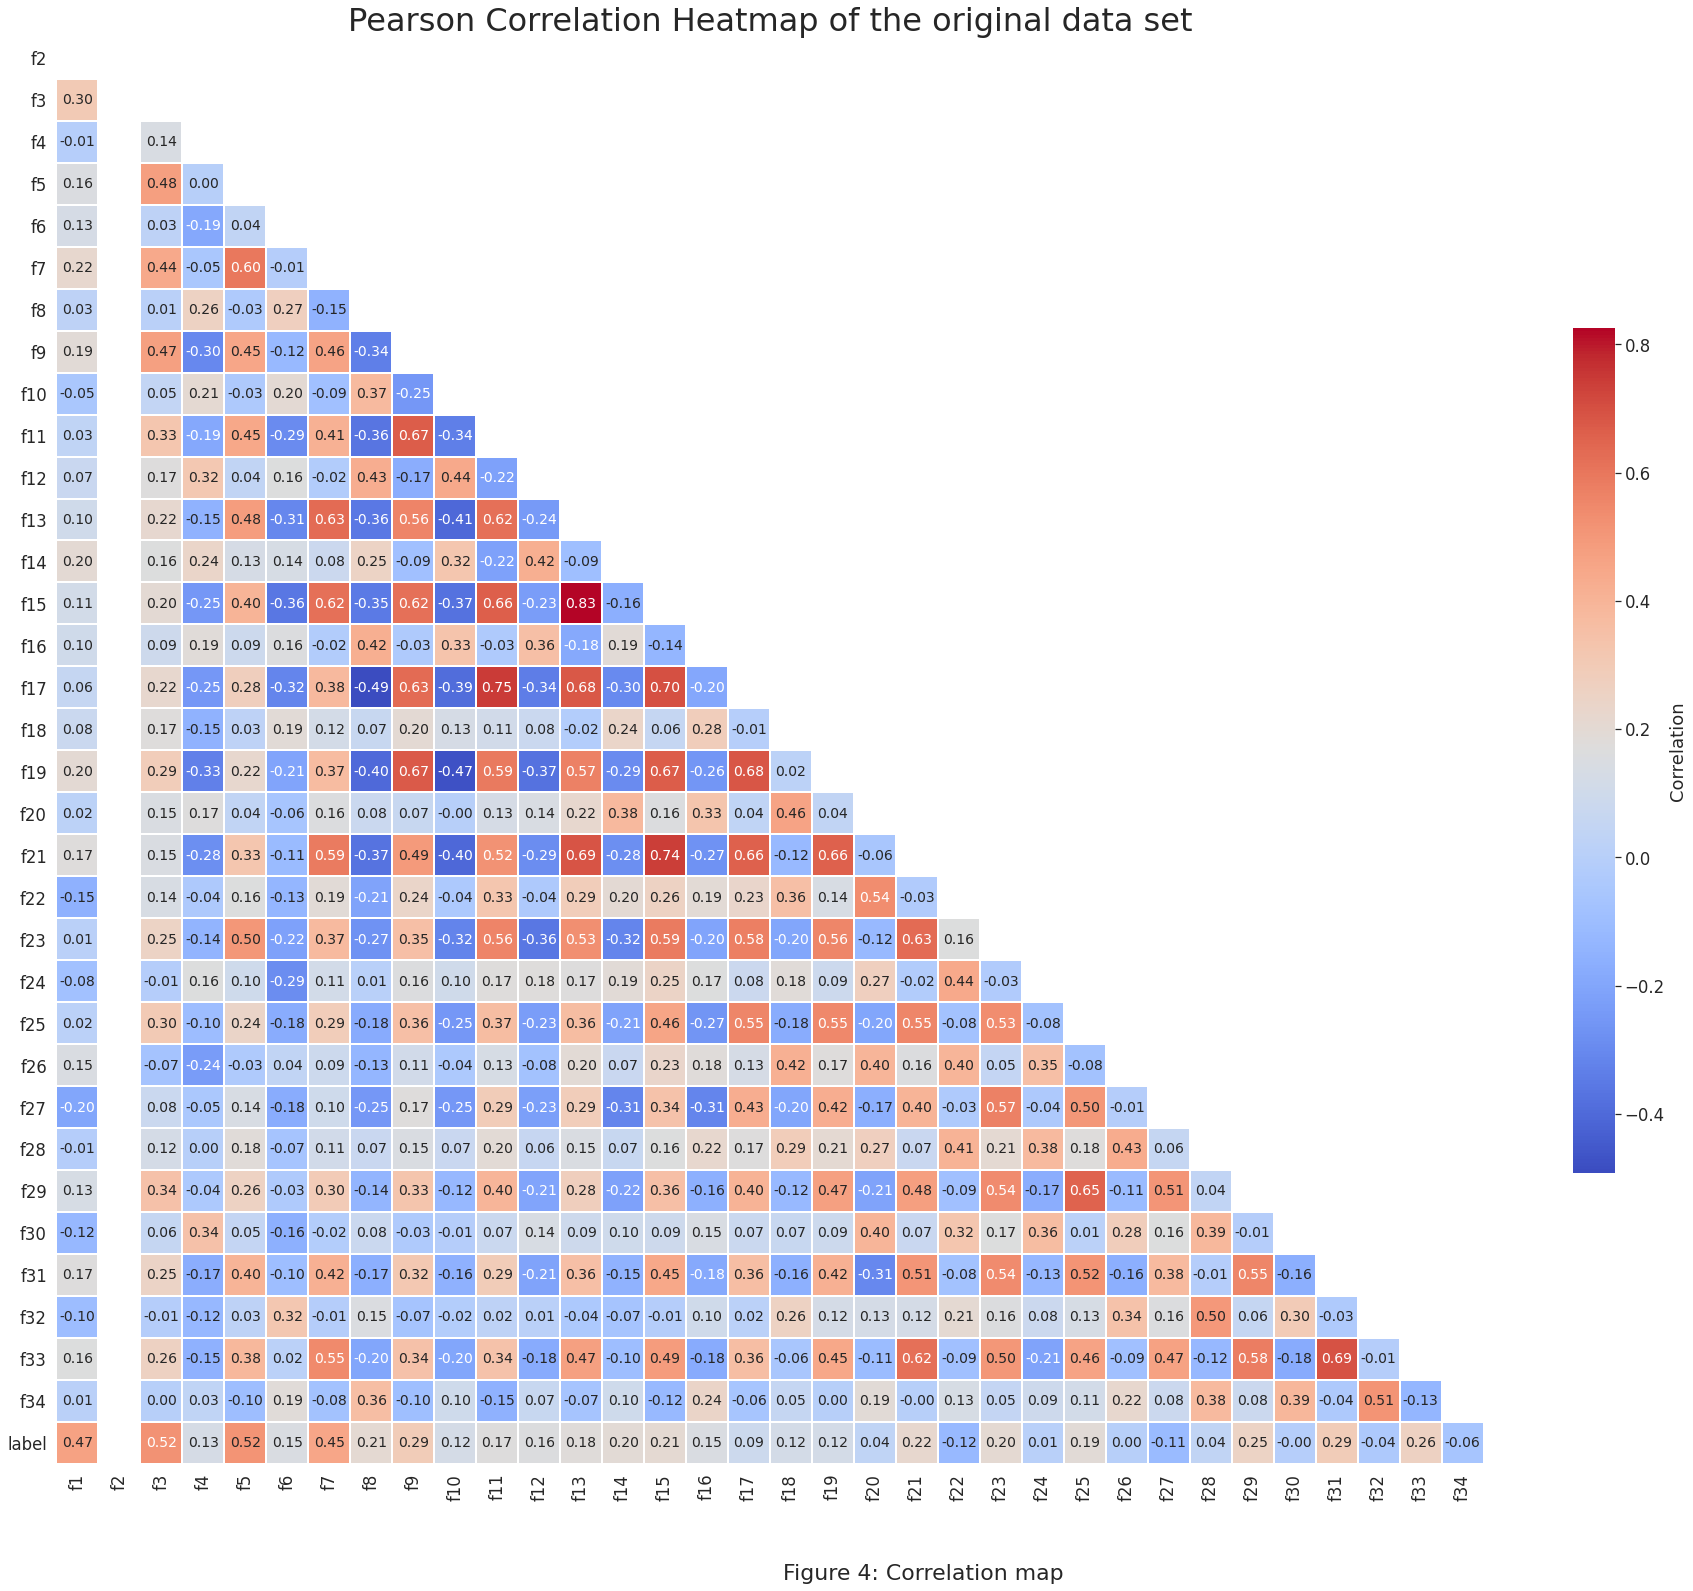

In [7]:
sns.set_style("white")
corr_df = df.corr()
mask = np.triu(corr_df)
mask = mask[1:, :-1]
corr_df = corr_df.iloc[1:,:-1].copy()

f,ax=plt.subplots(figsize=(26,24))
fig = sns.heatmap(corr_df,annot=True,fmt=".2f", ax=ax, 
                  linecolor="white", linewidths=0.1 ,
                  mask = mask, square=True, 
                  annot_kws={"size": 14}, cbar_kws = {"shrink":0.5, 'label': 'Correlation'},
                  cmap= 'coolwarm', rasterized=False)

plt.xticks(rotation= 90, ha = 'center')
plt.yticks(rotation= 0)

plt.title('Pearson Correlation Heatmap of the original data set', fontdict= {"fontsize":32})
plt.figtext(0.5,0.02, "Figure 4: Correlation map", fontsize = 22, ha = 'center')
plt.tight_layout()
plt.show()

### Observations:
- Feature 2 contations only 0 values and it encodes no useful information
- Features 13 and 15 are strongly correlated with each other 
- Features 1,3,5,7 show a mild correlation with target label whereas features 20,24,26,28,30,32 and 34 show near 0 correlation with target label.
    

# 3 Constructing the pipeline

## 3.1 Partitioning
To better understand the performance of a trained model, it is essential that we **test it on a subset of data which is yet-unseen by trained model**. Otherwise we might overfit our model to provide excellent performance on available dataset but when we feed new, yet-unseen, data samples into our machine learning model it provides poor results. To replicate the effect of testing on yet-unseen data, we **split** data at hand into training and test sets. **25%** of the total amount of data is allocated for testing purposes. This subset of data is used **only** to test the performance of the final model **at the end**. To maintain the **IID assumption** about dataset instances, we used **stratified sampling technique** to split train and test datasets. Stratified means that the distribution of each target label is kept the same in both subsets.  


To find appropriate **hyperparameters for a classification algorithm**, we need another set of data to validate different combinantions of such parameters. We use **Stratified k-fold cross validation** technique. It is a validation technique for assessing how the results of a statistical analysis will generalize to an independent data set (figure 5). It works as follows:  

1. We split our data into _K_ equal sized sets
2. We use _K-1_ subsets to train the model and _K_'th subset is used to evaluate its performance
3. We repeat step-2 _K_ times by replacing each time the validation set and measuring the performance score (e.g. Accuracy)
4. The _K_ results can then be averaged to produce a single performance estimate for given set of hyperparameters
5. We repeat step 1-4 for all desired combinations of hyperparameters and select the combination which provides the best estimation  


<figure>
  <center>
  <img src="https://i.imgur.com/sF2b5mm.png" alt="Drawing" style="width: 650px;height: 450px"/>
    </center>
</figure>

At the end of validation process, final model is trained using optimal configurations on all (train + validate) dataset. 
**The advantage of this method is that all observations are used for both training and validation, and each observation is used for validation exactly once.**  Stratified means that each subset contains the same underlying distribution of target labels. In case of binary classification it means that each partition set contains approximately the same proportion of positive and negative class labels. 


## 3.2 Features selection
In our work we approach dimensionality reduction (See section 6) from **two different viewpoints.**  
First we use a manual features selection by analyzing the correlation matrix. We drop (one of those) features which have $|\rho| > .80$ or the feature which has $|\rho| < 0.05 $ with target variable.  
Since $\rho$ only indicates the **linear relationship** among predictors, such selection can also result in loss of useful information. We empirically tested our machine learning models with and without these predictors and got comparable results. This feature selection method allows us to **directly interpret** the results of machine learning models as training data stays in original input space.  
<br>
<br>

We introduce feature projection techniques in the last part of our work. These approaches use linear projections of original data in such a way that newly created features space encodes certain data properties and has much lower dimensionality.  

## 3.3 Metrics
The metrics used to measure the performance are following.

### Accuracy
Accuracy is the proportion of correct predicitons among the total number of cases examined:
 
$$
Accuracy = \frac{TP + TN}{TP + FP + FN + TN}
$$

Accuracy is probably the most famous performance metric but it does not tell the whole story all the time.  
In the case of **unbalanced data**, for example 99% vs 1%, a naive model can achieve a 99% accuracy score by predicting everything as the majority class.  

### F1 Score
    
F1 score has two main ingredients:
* __Precision__ for a given class is the number of true positives (i.e. the number of items correctly labelled as belonging to the positive class) divided by the total number of elements labelled as belonging to the positive class:
$$
    Precision = \frac{TP}{TP + FP}
$$
<br>

* __Recall__ (also known as _sensitivity_) is defined as the number of true positives divided by the total number of elements that actually belong to the positive class
$$
    Recall = \frac{TP}{TP + FN}
$$
<br>

The F1 score is the harmonic mean of precision and recall.
 
$$
    F_1 = 2 * \frac{Precision * Recall}{Precision + Recall}
$$
 
We select F1-score as the performance metric and K-fold cross validation measures the average F1-score for each fold to find the best set of hyperparameters.


In [8]:
from sklearn.model_selection import train_test_split, GridSearchCV

drop_label = ["label"]
drop_lowCorr = [f"f{i}" for i in [2,13,20,24,26,28,30,32,34]]

y, X = df["label"], df.drop(drop_label, axis=1)

rs = 99
ts = 0.25
X_train_all, X_test_all, y_train, y_test = train_test_split(X, y, test_size= ts, 
                                                    stratify= y, random_state=rs)

X_train, X_test = X_train_all.drop(drop_lowCorr, axis=1), X_test_all.drop(drop_lowCorr, axis=1)

## 3.4 Feature scaling
Although all features of our dataset are continuous values between [-1, 1] range, we prefer converting them into standard normal distribution using a well known standardization process. It works as follows,

$$
z = \frac{x - \mu}{\sigma}
$$
where
- x is the original feature vector
- $\mu$ is the sample mean for that feature
- $\sigma$ is the standard deviation of the x feature  

To avoid any kind of data leakage $\mu$ and $\sigma$ are calculated only from training data and the transform is applied to both training and test sets. 

## 3.4 Outliers management

In statistics, an outlier is an observation point that is distant from other observations.  
Different machine learning methods behave differently when they are trained on data which has outliers. Hard margin SVM is an example of a machine learning model which is highly sensitive to outliers.  

To detect outliers within data at hand, we observe the distribution of scaled training data set using boxplots. A boxplot nicely encodes the data distribution using interquartile range. (Figure 7)


The figure 8 shows the distribution of the **Good** and **Bad** return samples after the normalization process, labeling as outliers all the points lower than "Q1 −1.5IQR" or higher than "Q3 +1.5IQR". Where Q1 and Q3 are, respectively, the lower and upper quartile and IQR is the interquartile range. (Figure 7)

<!-- ![alt text](bp.png) -->

<figure>
  <center>
      <img src="https://i.imgur.com/xckdJg4.png" alt="Drawing" style="width: 50%;height: 50%"/>
  </center>
</figure>

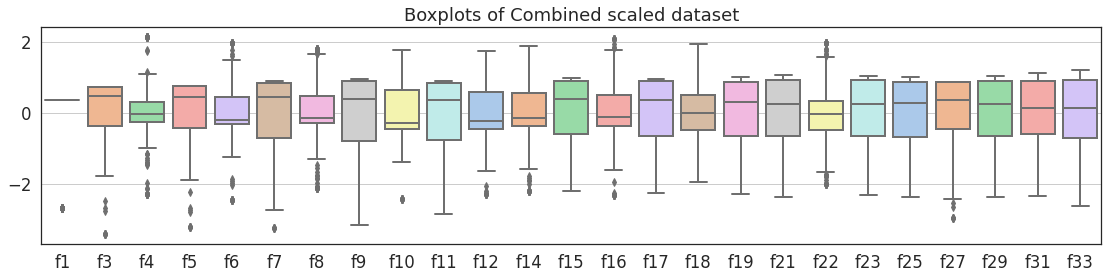

In [9]:
mean_train, std_train = X_train.mean(0), X_train.std(0)
X_train_std = (X_train - mean_train) / std_train

plt.figure(figsize = (19,4))
plt.grid(True)
sns.boxplot(data = X_train_std, palette="pastel", linewidth=2 , whis= 1.5)
plt.title("Boxplots of Combined scaled dataset")
plt.show()

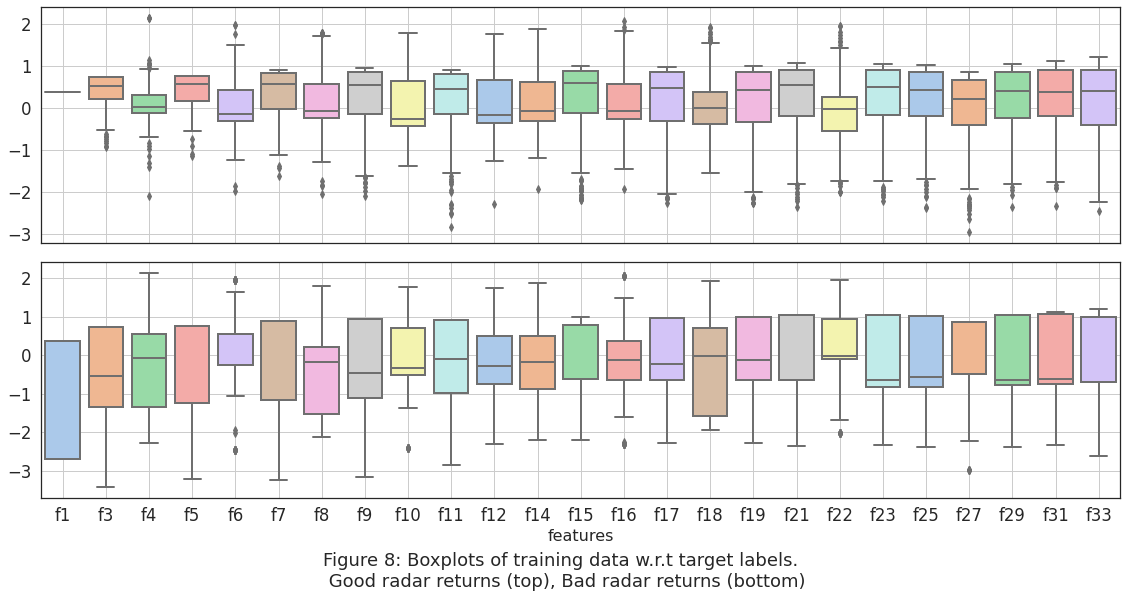

In [10]:


fig, axs = plt.subplots(2,1,figsize = (16,8), sharex= True)
sns.boxplot(data = X_train_std[y_train == 1], palette="pastel", linewidth=2, ax = axs[0], whis= 1.5)
# plt.figure(figsize = (16,6))
sns.boxplot(data = X_train_std[y_train == 0], palette="pastel", linewidth=2, ax = axs[1], whis= 1.5)
# plt.title(' Correlation Heatmap of the original data set', fontdict= {"fontsize":32})
plt.figtext(0.5,-0.04, "Figure 8: Boxplots of training data w.r.t target labels. \n \
Good radar returns (top), Bad radar returns (bottom)", fontsize = 18, ha = 'center')
plt.xlabel("features", size = 16)
for ax in axs:
    ax.grid()
plt.tight_layout()
plt.show()

If we remove all the outliers using interquartile rule, it would impact mostly the *Good* radar returns. *Bad* returns have very few outliers and **most of them are within the range of 3$\sigma$ (standard deviation) from mean.** 3$\sigma$ corresponds to 99.7% of the area under the bell curve of Standard normal distribution.  
Removing outliers will definitely change the underline distribution of *Good* and *Bad* class labels. We may distinguish *Good* returns from bad ones considering them as _outsiders_, hence removing outliers from *Good* returns is not preferable.


## 3.5 Class Balancing 

Class imbalance is a phenomenon in which one target label is highly prevalent in a given dataset. Datasets like fraud or disease (e.g. Cancer) detection often suffer from this issue as one class occurs rarely in training data. It makes it harder for the learner to make reliable predictions when working imbalanced data.  
Although the dataset in our case is not highly imbalanced, it is neither perfectly balanced. To make the distribution of target classes even, we use an oversampling technique called SMOTE.  
<br>

Synthetic Minority Over-sampling Technique [3] or simply SMOTE was first introduced by Chawla, et al [1]. in 2012.  **It selects a random data point** $x_i$ from the minority class and finds its **k-nearest minority class neighbors** (k is a hyperparameter). Among those k neighbors, SMOTE selects at random one point $x_{zi}$ and a new sample is created on the segment joining $x_i$ with $x_{zi}$. The new point can be defined as $x_{new} = x_i + \lambda(x_i - x_{zi})$ s.t $\lambda \in [0,1]$

<figure>
  <center>
      <img src="https://i.imgur.com/oQ8ej7P.png" alt="Trulli" style="width:80%; height:80%"/>
  </center>
</figure>

Any methods which alters the underlying distribution of our data, **must only be applied on training data**. Therefore SMOTE is applied only on the training data and test\validation datasets are unchanged.
The full classification pipeline is shown in figure A.
<br>
<br>
<figure>
  <center>
      <img src="https://i.imgur.com/VWv8Lqn.png" alt="Trulli" style="width:50%; height:50%">
  </center>
</figure>


In [11]:
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn import tree
from sklearn.metrics import classification_report, f1_score, auc, accuracy_score
from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve
from sklearn.datasets import make_classification 

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

import statsmodels.api as sm
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec

In [12]:
import json
def dprint(d):
    print(json.dumps(d, sort_keys=False, indent=4),"\n")
    
    
def report(y_true, y_pred, title = "", 
           params = None, show_cm = True, show_params = True):

    nl = '\n'
    sp = "*"*len(title)
    
#     print("__"*30 + nl)
    if title:
        title = "Classification report for " + title + " on yet-unseen data"
        sp = "*"*len(title)
        print(sp + nl + title + nl + sp +nl)
    
    acc = accuracy_score(y_true, y_pred)
    f_score = f1_score(y_true, y_pred)
    print("Accuracy: {:.3f}".format(acc))
    print("f-score: {:.3f}".format(f_score))
    
    if params and show_params:
        new_params = {}
        for k in params:
            new_params[k.split("__")[-1]] = params[k]
            
        print("\nBest Parameters:")
#         pprint(new_params, indent = 4)
        dprint(new_params)
        
#     print(classification_report(y_true, y_pred))
    if show_cm:
        plt.figure(figsize = (6,5))
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot = True, 
                    cmap = 'YlGnBu', 
                    annot_kws={"size": 18},
                    linecolor = 'w',
                    linewidth = 4
                   )
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted labels")
        plt.ylabel("True labels")
    
    return (acc, f_score)
    
scores = {}
gs_trained_models =  {}

In [13]:
def run_tests(model, X_train, X_test, y_train, y_test, 
              params, scores_dict, model_dict, 
              show_cm = True, show_params = True):
    
    grid_search = GridSearchCV(model, 
                               params, 
                               scoring = 'f1',
                               n_jobs=5,
                               cv=5,
                    )
    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    model_dict[name] = grid_search.best_estimator_
    acc, fscore = report(y_test, y_pred, name, grid_search.best_params_, show_cm, show_params)
    scores_dict[name] = fscore
    plt.show()

# 4. Analysis of classification models

Suppose a binary classification problem in which data is distributed as following:

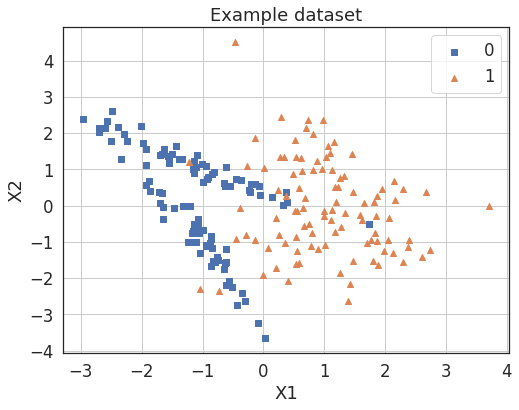

In [14]:
X, y = make_classification(n_samples=200, n_features=2, 
                           n_informative=2, n_redundant=0, 
                           n_classes=2, random_state=5)

fig = plt.figure(figsize=(8,6))

plt.scatter(X[y == 0, 0], X[y == 0, 1], marker='s', label = 0)
plt.scatter(X[y == 1, 0], X[y == 1, 1], marker='^', label = 1)

plt.legend()
plt.grid(True)
plt.title("Example dataset")
plt.xlabel("X1")
plt.ylabel("X2")

plt.show()

We need to draw a decision boundary so that each class will end up in (possibly) correctly classified region.  
But there exist several **hypothesis classes which may draw different decision boundaries.**

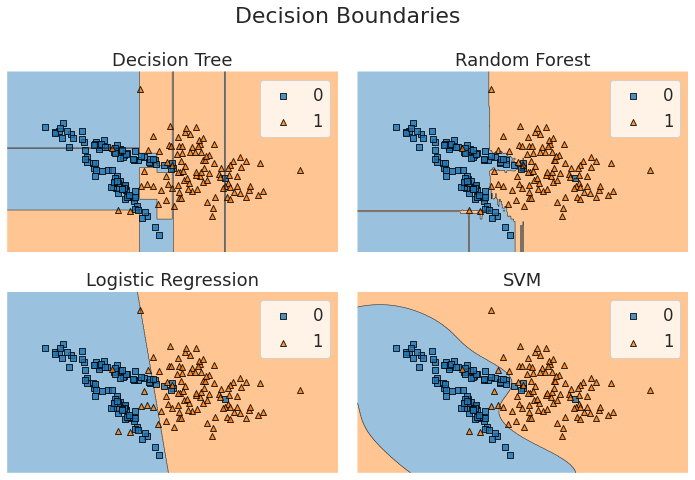

In [15]:
# Initializing Classifiers
clf1 = LogisticRegression(random_state=rs)
clf2 = DecisionTreeClassifier(random_state=rs)
clf3 = RandomForestClassifier(random_state=rs)
clf4 = SVC(kernel = 'rbf', random_state=rs)

gs = gridspec.GridSpec(3, 2)
fig = plt.figure(figsize=(10,10))
labels = ['Decision Tree', 'Random Forest','Logistic Regression', 'SVM']
for clf, lab, grd in zip([clf2, clf3, clf1, clf4],
                         labels,
                         [(0,0), (0,1), (1,0), (1,1)]):
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig_ = plot_decision_regions(X=X, y=y, clf=clf, legend=2, ax = ax)
    plt.tick_params(
        axis= 'both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        left = False,
        labelbottom=False, # labels along the bottom edge are off
        labelleft = False)

    plt.legend(loc = 'upper right')
    plt.title(lab)

fig.suptitle("Decision Boundaries", fontsize = 22)
plt.tight_layout()
plt.show()

* Which one will provide better generalizability?  
* What if we have data with many more dimensions?  
* Can we explain how a model made a certain prediction?

<br>
In this section we try to answer these questions by looking into the mathematical basis of different hypothesis classes. This will lead us to understand how we can choose an appropriate ML method which suits our problem at hand. 

<br>
<br>
<br>

## “WHEN STUCK, SWITCH TO ANOTHER PERSPECTIVE”
<br>

__by Patrick Winston (1943 - 2019)__
<br>
<hr>


## 4.1 Decision Trees

Decision Tree is a supervised learning algorithm [5] whose goal is to create a training model to predict the class or value of the target variable by learning simple decision rules inferred from training data. Decision trees are **locally constant functions which divide predictor space into non-overlapping regions** having boundaries parallel to the axis. The label assigned is the most commonly occurring class in that region.  
At each step the model chooses the best predictor to split according to some criteria. Since it is computationally infeasible to consider every possible partition of the feature space when training the model, it takes a **top-down greedy approach** that is known as recursive binary splitting. This approach is greedy in the sence that at each step it performs a **locally optimal split**, rather than the one that would lead to the globally optimal result.  
Gini index and cross entropy are two well known criteria to measure the goodness of a split.  

__1. GINI index:__  
    GINI index is an impurity measure of a given node and it is lowest when a node contains only samples belonging to one single class. It is defined as.
    $$
        GINI = \sum_{k = 1}^{K} {P}_{mk} (1-{P}_{mk})
    $$
    ${P}_{mk}$ is the proportion of k'th class in region m and K is the total number of classes.
    We prefer the split which yields the least GINI index.

__2. Cross Entropy:__  
    Entropy is also an impurity measure and for a given node it can be calculated by
    $$
        Entropy(t) = - \sum_{j = 1}^{C} P(j|t) * \log(P(j|t)
    $$
    To measure the quality of a split we use information gain:
    $$
    GAIN_{split} = Entropy(Parent) - \sum_{i = 1}^{k} \frac{n_i}{n}Entropy(i)
    $$
    The split yielding highest Gain is prefered.

The **stopping criteria** for splitting plays a vital role to prevent overfitting on training data. Pre-pruning is one such method which stops the algorithm before it becomes a fully grown tree. Among different stopping conditions, we choose tree depth and minimum impurity decrease as a hyperparameter for our model.  
We evaluate all the combinations of the following hyperparameters via K-fold cross validation:

- criterion: {gini, entropy}
- max depth: {6,8,10,12}
- min impurity decrease: {0.0,0.001,0.0001}

Best performing hyperparameters and classification results are as following:


*********************************************************
Classification report for DecisionTree on yet-unseen data
*********************************************************

Accuracy: 0.920
f-score: 0.938

Best Parameters:
{
    "criterion": "gini",
    "max_depth": 6,
    "min_impurity_decrease": 0.0
} 



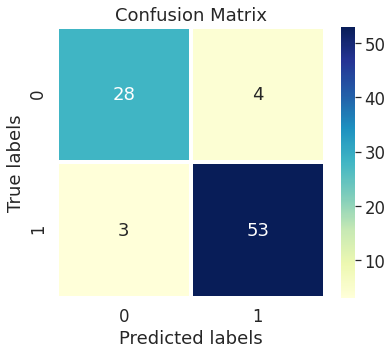

In [16]:
models = {
    "DecisionTree":DecisionTreeClassifier(random_state=rs),
#     "RandomForestClassifier":RandomForestClassifier(random_state=rs),
#     "LogisticRegression":LogisticRegression(random_state=rs),
#     "SVM":SVC(random_state=rs)
}

params = {
        "decisiontreeclassifier__min_impurity_decrease": [0.0,0.001,0.0001],
        "decisiontreeclassifier__max_depth": [6,7,8,10,12],
        "decisiontreeclassifier__criterion":["gini", "entropy"]
    }

for name in models:
    model = make_pipeline(StandardScaler(), SMOTE(random_state=rs), models[name])
    run_tests(model, X_train, X_test, y_train, y_test, params, scores, gs_trained_models)


The strong point of decision trees is their **simplicity and explainability**. They are **inexpensive** to construct, have very **low inference time** and very easy to explain since a graphical representation of internal nodes and decisions is often available (at least for small trees). We plot the internal tree strcture of trained model in figure 9. The tree has depth of 6 nodes. At each decisional node, we know the instances per target class label and prevelant class. The split condition and gini index for splits is also provided.  

The major downside of decision trees is their **tendency to overfit the training data.** To overcome this aspect they are often used with bagging or boosting techniques to enhance their generalization ability. 


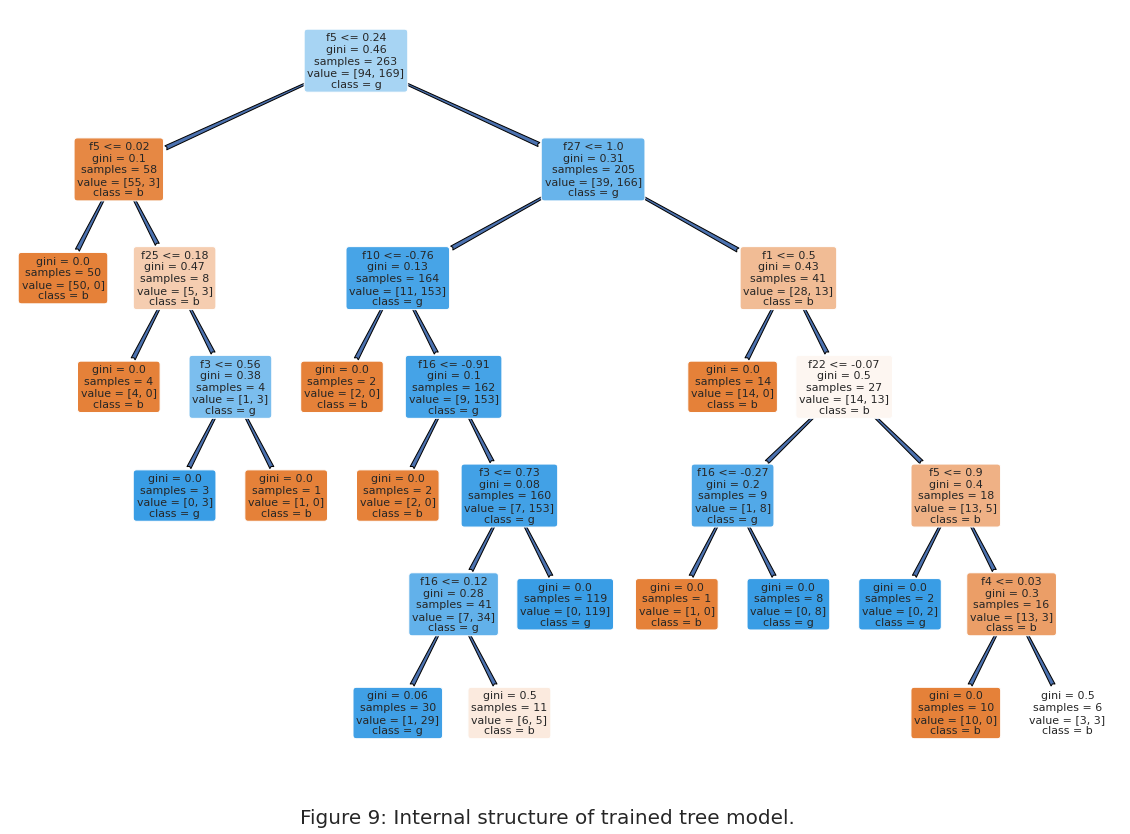

In [17]:
clf = gs_trained_models["DecisionTree"].named_steps['decisiontreeclassifier']
clf.fit(X_train, y_train)

fig, ax = plt.subplots(figsize=(20,14))
out = tree.plot_tree(clf,
               feature_names= X_train.columns,
               class_names = ["b","g"],
               fontsize= 11, 
               filled = True, 
               label = 'all',
               precision= 2,
               rounded = True, 
#                ax = ax
              )
for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(1)
        arrow.set_arrowstyle("fancy")
        
plt.figtext(0.5,0.07, "Figure 9: Internal structure of trained tree model.", fontsize = 20, ha = 'center')
plt.show()


## 4.2 Random Forest

Random Forest is an ensemble of Decision Trees, generally trained via **bagging methods** [5]. The bootstrap aggregation or bagging method combines the prediction bagging functions, often called weak learners, learned from multiple data sets, with a view to improving overall prediction accuracy. Ideally bagging requires obtaining multiple independent training sets from the population but it is not always possible. In practice, we use the so-called **bootstrap data sets by sampling with replacement** from the original training set. Bootstrap datasets have the same cardinality as the original dataset.  

Random forests differ from bagging techniques as they use bootstrap data sets in combination with _feature bagging_. In feature bagging, to construct each tree, we randomly select a subset of features (typically $\log(p)$ or $\sqrt{p}$) and use only these features to find the best split along the way. Trees generated using this technique no longer make the same splits hence we overcome the correlation problem caused by bagging.  

<figure>
  <center>
      <img src="https://i.imgur.com/x06pwJb.png" alt="Trulli" style="width:70%; height:70%">
  </center>
</figure>

For classification, the target label is calculated by taking a majority vote from all trained trees in the forest. In addition to hyperparameters introduced in section 5.1, we tuned the number of trees to construct and the subset feature size used in feature bagging.  
<br>
We report the classification results and optimal hyperparameters combinantion in the following section.  

Additional hyperparameters:
- n estimators: {80, 100, 120}
- max features: {sqrt, log2}


*********************************************************
Classification report for RandomForest on yet-unseen data
*********************************************************

Accuracy: 0.943
f-score: 0.957

Best Parameters:
{
    "criterion": "entropy",
    "max_depth": 8,
    "max_features": "sqrt",
    "min_samples_split": 2,
    "n_estimators": 120
} 



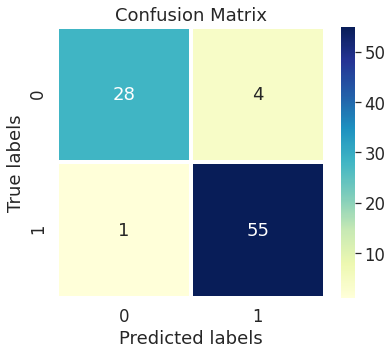

In [18]:
models = {
#     "DecisionTree":DecisionTreeClassifier(random_state=rs),
    "RandomForest":RandomForestClassifier(random_state=rs),
#     "LogisticRegression":LogisticRegression(random_state=rs),
#     "SVM":SVC(random_state=rs)
}

params = {
        "randomforestclassifier__n_estimators":[80,100,120],
        "randomforestclassifier__criterion":["gini", "entropy"],
        "randomforestclassifier__max_depth":[8,10,12],
        "randomforestclassifier__min_samples_split":[2,4,6],
        "randomforestclassifier__max_features":['sqrt','log2'],
    }

for name in models:
    model = make_pipeline(StandardScaler(),SMOTE(random_state=rs), models[name])
    run_tests(model,X_train, X_test, y_train, y_test, params, scores, gs_trained_models)

As shown by the confusion matrix above, we have decreased the number of misclassified samples from 11 to 5 and the F1 score improved by 5.6%. Random forests are more robust to noise and outliers so they are stable learners as compared with decision trees.  
<br>

While the advantage of Random Forest in the sense of enhanced generalizability and robustness is clear, we should also consider its negative aspects, They have higher computational cost w.r.t decision trees and longer inference time. A majot downside of random forests is the loss of interpretability. Specifically, a random forest consists of many trees, thus making the prediction process both hard to visualize and interpret. However, Random Forest can provide some useful information about the input features and their importance in decision making. Each internal node of a decision tree induces a certain decrease in the training loss; we can define the impurity-based importance for feature $x_j$ in tree $T$ as, 
$$
\textbf{IMP}_{T}(x_j) = \sum_{v\ \in\ {T}} \nabla_{loss}(v) \mathbb{1}(x_j\ is\ associated\ with\ v)
$$
where $v$ is a decision node of tree $T$. To extend this idea within the random forest, the feature importance is averaged over all trees of the forest. Figure 10 shows the feature importance for different features used in random forest generation. 

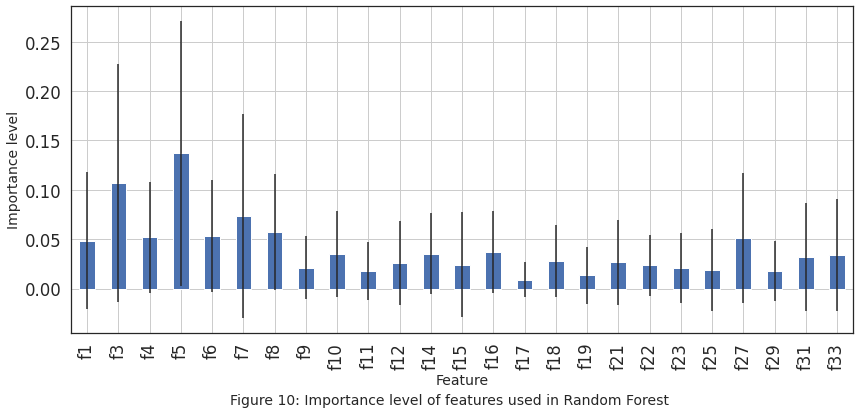

In [19]:
num_cols = X_train.select_dtypes(include= ['Float64', 'int64']).columns
clf = gs_trained_models["RandomForest"].named_steps['randomforestclassifier']

plt.figure(figsize = (14,6))
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
forest_importances = pd.Series(importances, index=num_cols)
forest_importances.plot.bar(yerr=std)
# order = np.argsort(importances)
# plt.bar(x = num_cols[order][::-1], height= height[order][::-1])
# plt.title("Importance level of features used in Random Forest")
plt.xlabel("Feature", size = 14)
plt.ylabel("Importance level", size = 14)
plt.grid()
plt.figtext(0.5,-0.04, "Figure 10: Importance level of features used in Random Forest", fontsize = 14, ha = 'center')
plt.show()

The feature importance has very high standard deviation among trained trees and therefore no conclusive information can be derived in our case.

## 4.3 Logistic Regression

Logistic regression is a well-known method in statistics and machine learning that is used to predict the probability of an outcome, and is especially popular for classification tasks. [6]

In logistic regression, the response variable $Y$ is usually interpreted as the probability of an event happening $(Y = 1)$ or not happening $(Y = 0)$. $P$ is the probability of that event happening ($Y = 1$) and $1-P$ is the probability of that event not happening $(Y = 0)$. If we consider all instances of response variables in our training data $T$ as IID, then P can be estimated using MLE: 

$$
    MLE =  \prod_{i \in T}^{} P_i^{Y_i} (1-P_i)^{1 - {Y_i}} \\ 
$$

by taking log of both sides,

$$
    \log_{MLE} = \sum_{i \in T} Y_i\log(P_i) + (1-Y_i)\log(1-P_i) \tag{1}
$$

Recall that the log odds ratio (or _logit_) for an event happening is defined as: $\log\big(P/(1-P)\big)$
We assume that the **logit has a linear relationship with the predictors** and log-odds for even $Y = 1$ can be written as,
$$
    logit = \log\big(\frac{P}{1-P}\big) = W^T\cdot X + b \\
$$

Hence, 
$$
    P = \frac{1}{1 + e^{-W^T\cdot X + b}} \tag{2}
$$

by substituting value of P in eq 1,

$$
    \log_{MLE} = \sum_{i \in T} Y_i\log\big(\frac{1}{1 + e^{-W^T\cdot X_i + b}}\big) + (1-Y_i)\log\big(1-\frac{1}{1 + e^{-W^T\cdot X_i + b}}\big)
$$
which simplifies to,

$$
    \log_{MLE} = \sum_{i \in T} Y_i (W^T\cdot X_i + b)) + (1-Y_i)\log\big(\frac{1}{1+e^{W^T\cdot X_i + b}}\big)
$$
Different optimization techniques (like gradient descent) are used to find the solution for $\hat{w} = argmax_w \log_{MLE}$. 
<br>

The function described in eq 2 is famously known as _sigmoid fucntion_ and we plot it in figure 11.

<figure>
  <center>
      <img src="https://i.imgur.com/DxaKSBb.png" alt="Drawing" style="width:80%; height:80%" />  
  </center>
</figure>

    
The Sigmoid function takes the linear combination of predictors and maps it into a [0,1] interval giving us the $P(Y=1)$.  
Once the probabilities are obtained, the classification is made by applying a threshold (usually 0.5) on them, for example we assign the label 1 if $P ≥ 0.5$.  
To avoid overfitting, different kinds of regularization methods are used to reduce the complexity of the model. This operation is performed by restricting  the size of coefficients in vector $W$. We used l1 and l2 norms as regularization techniques in hyperparameters tuning. The former assigns zero values to needless weight coefficients and the later reduces their size to _near zero_ values. <br> <br> To control the effect of regularization we tuned another parameter, C. It represents the inverse of regularization. _Tol_ is the stopping criteria for learning algorithms. 
We tested all combinations of following hyperparameters via K-fold cross validation and detailed results are reported below.

- penalty: {'l1' ,'l2' }
- tol: {1e-2, 1e-3, 1e-4}
- C: {0.5 ,0.8, 1.0, 1.2, 1.5} 


***************************************************************
Classification report for LogisticRegression on yet-unseen data
***************************************************************

Accuracy: 0.886
f-score: 0.914

Best Parameters:
{
    "C": 1.5,
    "penalty": "l2",
    "tol": 0.01
} 



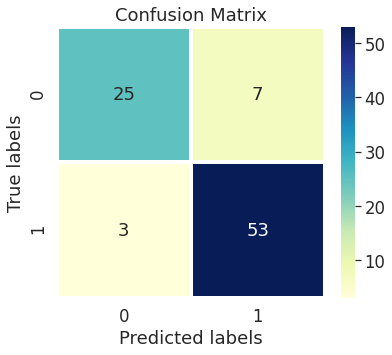

In [20]:
models = {
#     "DecisionTree":DecisionTreeClassifier(random_state=rs),
#     "RandomForest":RandomForestClassifier(random_state=rs),
    "LogisticRegression":LogisticRegression(random_state=rs),
#     "SVM":SVC(random_state=rs)
}

params = {
        "logisticregression__penalty": ['l1','l2'],
        "logisticregression__tol": [1e-2, 1e-3, 1e-4],
        "logisticregression__C": [0.5,0.8, 1.0,1.2, 1.5] 
    }

for name in models:
    model = make_pipeline(StandardScaler(),SMOTE(random_state=rs), models[name])
    run_tests(model,X_train, X_test, y_train, y_test, params, scores, gs_trained_models)

Logistic regression provides statistical interpration of the results. Since it calculates the probability of an instance belongig to a certain class, we can set the threshold for hard label classification according to problem at hand. A predicted probability close to 0 or 1 shows that model is very confident about its prediction whereas predictions which are closer to threshold value can be further evaluated with domain knowledge, without blindly accepting the results of the classifier.  
Since we have all continuos numerical predictors in our dataset, we can easily understand which feature correspond to Good returns and which one contribute mostly for Bad returns. The predictors which have coefficient value of near zero, are the ones which contain no useful information for learning process.  The coefficient $c_i$ represents the increase (or decrease, depending on its sign) in log odds of $Y=1$ for a predictor $f_i$ increases by one.

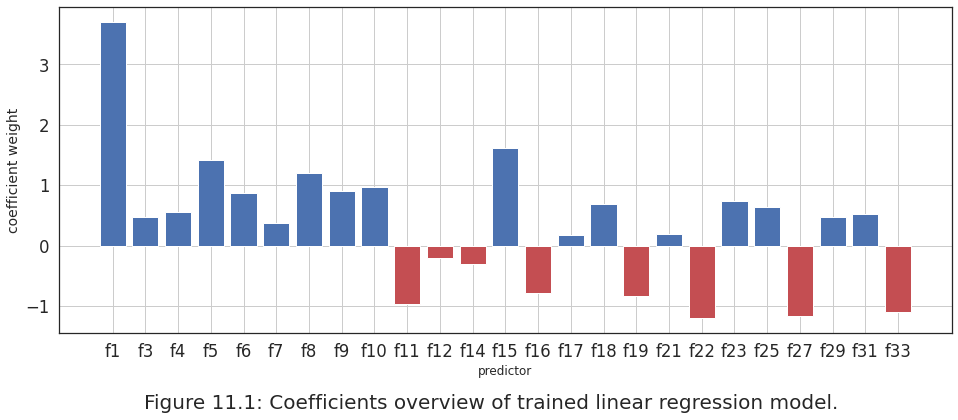

In [21]:
cls = gs_trained_models['LogisticRegression'].named_steps['logisticregression']
plt.figure(figsize = (16,6))

coeffs = cls.coef_.ravel()
mask = coeffs > 0
color = np.ones_like(mask, dtype='object')
color[mask] = 'b'
color[~mask] = 'r'

plt.bar(X_train.columns, coeffs, color = color)
plt.ylabel("coefficient weight", size = 14)
plt.xlabel("predictor", size = 12)
plt.figtext(0.5,-0.050, "Figure 11.1: Coefficients overview of trained linear regression model.", fontsize = 20, ha = 'center')
plt.grid()

We can get further information about these coefficients by using another Package 'statsmodel'.  
Statsmodel does not uses any regularization method so its results are different from those found above. It also uses different solver method to find best fit of coefficients.

In [22]:
exog, endog = sm.add_constant(X_train), y_train
sm_cls = sm.GLM(endog, exog, family=sm.families.Binomial())
res = sm_cls.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  label   No. Observations:                  263
Model:                            GLM   Df Residuals:                      237
Model Family:                Binomial   Df Model:                           25
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -46.280
Date:                Fri, 30 Jul 2021   Deviance:                       92.561
Time:                        21:29:09   Pearson chi2:                     208.
No. Iterations:                    23                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -41.2530   1.26e+04     -0.003      0.9

***********************************************************************
Classification report for Logistic Regression by GLM on yet-unseen data
***********************************************************************

Accuracy: 0.909
f-score: 0.932


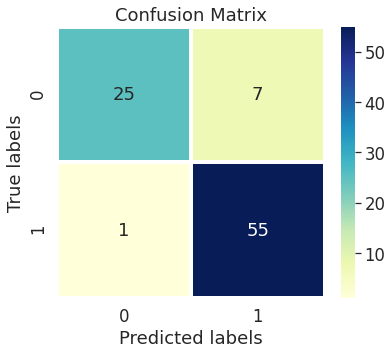

In [23]:
y_pred_gm = (res.predict(sm.add_constant(X_test)) > 0.5).astype(np.int)
_ = report(y_test, y_pred_gm, title = "Logistic Regression by GLM", 
       params = None, show_cm = True, show_params = False)

## 4.4 SVM

SVM is a supervised method that finds the hyperplane which **maximizes the margin between two classes.** It comes in different flavors which we discuss in this section one by one.

### 4.4.1 Hard-SVM
A hard-SVM assumes that the data is **linearly separable** and seeks for the hyperplane which perfectly separates target classes with the **largest margin**. The largest margin ensures lower generalization error on yet-unseen data. Margin is defined as the minimum distance between points in our data and the hyperplane. (Figure 13)

<figure>
  <center>
  <img src="https://i.imgur.com/xpxxOVm.png" alt="Drawing" style="width:80%; height:80%"/>
</center>
</figure>

A separating hyperplane is defined by $w, b$ such that $\forall i, y_i( w \cdot x_i + b) > 0$ and the margin equals $min\ | w\cdot x_i + b| $ (assuming $ \lVert w \lVert = 1$). The closest points to hyperplane are called _Support Vectors_ and they directly influence the position and orientation of the hyperplane. 
The problem of Hard-SVM can be defined as:

$$
\underset{(w,b):\ ||w|| = 1}{\operatorname{argmax}} \underset{i \in T}{\operatorname{min}} | w\cdot X_i + b | \\
s.t \ \forall i, y_i(w\cdot x_i + b) > 0
$$

Equivalently, it can be reformulated into,

$$
(w_0, b_0)=\underset{(w,b)}{\operatorname{argmin}} \frac{\lVert w \lVert ^2}{2} \\
s.t \ \forall i, y_i(w\cdot x_i + b) \ge 1 \\
\text{and solution is given by}\ \big ( \frac{w_0}{\lVert w_0 \lVert}, \frac{b_0}{\lVert w_0 \lVert} \big)
$$

Which can be defined in its dual form using Lagrange multipliers, 

$$
\underset{\alpha}{\operatorname{argmax}} \sum_{i}^{m} \alpha_i - \frac{1}{2} \sum_i^{m} \sum_j^{m} \alpha_i \alpha_j y_iy_j (x_i\cdot x_j) \tag{3} \\
s.t \ \forall i,\ \alpha_i \ge 0\ and\ \sum_i^m \alpha_iy_i = 0 \\
and,\ \ w = \sum_i^m \alpha_iy_ix_i 
$$

The weight vector $w$ is a linear combination of training instances. A key to SVM's success is that for the fit, **only the position of the support vectors matter;** any points further from the margin which are on the correct side do not modify the fit; their position and number do not matter so long as they do not cross the margin. In eq 3, only the points on margin (support vectors) have $\alpha > 0$, all other points have $\alpha = 0$.

### 4.4.2 Soft-margin SVM

Hard Margin SVM can only find a solution when data is perfectly separable by a hyperplane but real world data rarely admit such properties. Often there may be many points within the margin or completely on the wrong side of the hyperplane (figure 13). In such cases, the best hyperplane is the one that has a minimum number of such violations and yet maximizes the margin size.  
A soft-margin SVM classifier allows a certain number of data samples to violate the margin boundaries and a penalty is charged for every _contaminant_ inside the margin or misclassified point. a soft-margin SVM problem can be defined as,  

$$
\underset{(w,b):\ ||w|| = 1}{\operatorname{argmin}} \frac{1}{2} {||w||}^2 + C \sum_i^m \xi_i \\
s.t \ \forall i, y_i(w\cdot x_i + b) \ge 1 - \xi_i\ \text{and}\ \xi_i \geq 0
$$

$\xi_i$ are called the slack variables and they represent each violation w.r.t margin boundary. The sum of all such errors is minimized to get the best separation.  Whereas, _C_ is the regularization term which trades off correct classification of training examples against maximization of the decision function’s margin. For larger values of C, a smaller margin will be accepted if the decision function is better at classifying all training points correctly. A lower C will encourage a larger margin, therefore a simpler decision function, at the cost of training accuracy.  
Similar to Hard-margin classifier, we can define soft-margin problem in it's dual form using Lagrangian multipliers,

$$
L(w,b,\alpha) = \frac{1}{2}(w\cdot w) + C\sum_i^m \xi_i - \sum_i^m \alpha_i[y_i(w\cdot x + b) + \xi_i -1] - \sum_i^m \eta_i\xi_i
$$
  
by taking partial derivatives and performing few simplifications, it gives us this nice form solution:  

$$
\underset{\alpha}{\operatorname{argmax}} \sum_{i}^{m} \alpha_i - \frac{1}{2} \sum_i^{m} \sum_j^{m} \alpha_i \alpha_j y_iy_j (x_i\cdot x_j) \tag{4} \\
s.t \ \forall i,\ \alpha_i \in [0, C] \ and\ \sum_i^m \alpha_iy_i = 0 \\
and,\ \ w = \sum_i^m \alpha_iy_ix_i 
$$

It is worth noticing that the slack variables only effect the values which $\alpha_i$ can assume. Regularization parameter C is an upper bound on the values of $\alpha_i$. 


### 4.4.3 Kernel SVM
So far we have talked about the cases when underline distribution of data allows us to separate them with a hyperplane in the input feature domain.  Soft margin SVM is able to handle outliers and noise in given data, but if the classes are distributed in non linear shapes (Figure 14), then we need non linear support vectors to define the margin and decision boundary.  

<figure>
  <center>
        <img src="https://i.imgur.com/i38RSo4.png" alt="Drawing" style="width:100%; height:100%"/>
  </center>
</figure>


To handle such data one possible solution is to map our data from input space to a feature space (figure 14a), fit nonlinear relationships with a linear classifier in feature space and finally map the decision boundaries back to the input space where data was not linearly separable (figure 14c). However, the mapping procedure has its own challenges as often it requires prior knowledge and mapping can be computationally expensive.  

Let's take a step back and observe the dual form solutions described in eq 3 and 4 . The SVM solution requires us to perform dot products between instances $x_i \ and \ x_j$ for $i,j \in m$. What if we can define a function which takes as input our training samples in their input space and provide us their inner product in feature space?. This method is famously known as the _Kernel Trick_. A kernel is a function for a mapping $\varphi$ which implements the inner product in feature space without ever building the full representation of the kernel projection $\varphi$.

$$
K(x_i, x_j) = \varphi(x_i)\cdot \varphi(x_j)
$$

The _Kernel trick_ is one of the reasons the SVM method is so powerful.  
The kernel SVM problem and solution in its dual form is given by:

$$
\underset{\alpha}{\operatorname{argmax}} \sum_{i}^{m} \alpha_i - \frac{1}{2} \sum_i^{m} \sum_j^{m} \alpha_i \alpha_j y_iy_j (\varphi(x_i)\cdot \varphi(x_j)) \tag{5} \\
s.t \ \forall i,\ \alpha_i \in [0, C] \ and\ \sum_i^m \alpha_iy_i = 0 \\
and,\ \ w = \sum_i^m \alpha_iy_i\varphi(x_i)
$$


Some of the most popular kernels are rbf , polynomial and sigmoid.  
- _K_ degree polynomial kernel is defined as:

$$
K(x_i, x_j)_{poly} = (1 + x_i\cdot x_j)^k \tag{6}
$$  

- RBF (radial basis function) kernel computes the distance using a gaussian curve and it is defined as:

$$
K(x_i, x_j)_{rbf} = e^{-\frac{||x_i - x_j||^2}{2\sigma}} \tag{7}
$$

The Gaussian kernel provides smaller values if the instances are far away from each other (in the original domain) and closer to 1 if they are close. σ is a parameter that controls the scale determining what we mean by “close.”  

We tested all possible combinations of following hyperparameters via K-fold cross validation and detailed results are reported below.

- kernel: {'linear', 'rbf', 'poly'}
- gamma: :{'scale', 'auto'}
- C: {0.5,0.8, 1.0,1.2, 1.5} 
- tol: {1e-2,1e-3,1e-4}


************************************************
Classification report for SVM on yet-unseen data
************************************************

Accuracy: 0.943
f-score: 0.956

Best Parameters:
{
    "C": 0.8,
    "gamma": "auto",
    "kernel": "rbf",
    "tol": 0.01
} 



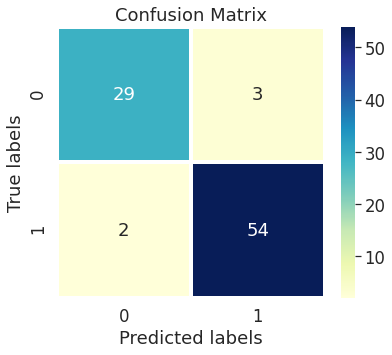

In [24]:
models = {
#     "DecisionTree":DecisionTreeClassifier(random_state=rs),
#     "RandomForest":RandomForestClassifier(random_state=rs),
#     "LogisticRegression":LogisticRegression(random_state=rs),
    "SVM":SVC(random_state=rs)
}

params = {
        "svc__kernel": ['linear', 'rbf', 'poly'],
        "svc__gamma" :['scale', 'auto'],
        "svc__tol": [1e-2,1e-3,1e-4],
        "svc__C": [0.5,0.8, 1.0,1.2, 1.5] 
    }

for name in models:
    model = make_pipeline(StandardScaler(),SMOTE(random_state=rs), models[name])
    run_tests(model,X_train, X_test, y_train, y_test, params, scores, gs_trained_models)

# 5. Dimensionality reduction

Dimensionality reduction is the transformation of data from a high-dimensional space into a low-dimensional space so that the low-dimensional representation retains some meaningful properties of the original data.  There are several reasons to reduce the dimensionality of the data. First, high dimensional data impose computational challenges. Moreover, in some situations high dimensionality might lead to poor generalization abilities of the learning algorithm.   
Principal Component Analysis (PCA) and Random projections are two examples of dimensionality reduction techniques. Both methods use feature projection techniques where these projections are linear transformations of a given dataset from high dimensional space to a lower dimensional space. We briefly explain the philosophy behind these approaches and select the one which is appropriate for our problem.  

## 5.1 Random Projections
    
The idea behind Random projections is to map our data in a new, low dimensional space in such a way that preserves the Euclidean distances between instances of data. We do not care about the reconstruction of our data back into its original space. [4]
<br>

Precisely, it is the $R^d \mapsto R^n$ transformation given by $x  \longmapsto Wx $ s.t $ n\ll d\ \text{and}\ \forall i, j \in m\ \ \frac{\lVert Wx_i - Wx_j \rVert}{\lVert x_i - x_j \lVert} \approx 1$  
Interestingly we can perform this transformation by using a random matrix W s.t $ W_{ij}  \sim \mathcal{N}(0,\,1/n)\ $ if we follow some constraints given by **Johnson-Lindenstrauss lemma:**
<br>
<br>
given $\ \epsilon \in (0,1)\ $ the tolerance level, m points in our dataset and 
$$
n \geq \frac{4 \log m}{\frac{\epsilon^2}{2} - \frac{\epsilon^3}{3}} \tag{i}
$$
then there exist a linear mapping $f: R^d \mapsto R^n$ s.t $\forall i, j \in m$ 
$$
(1-\epsilon) \lVert x_i-x_j \lVert \ \leq \ \lVert f(x_i) - f(x_j) \lVert \ \leq \ (1+\epsilon) \lVert x_i-x_j \lVert
$$
<br>
<br>
In our case $f$ is simply $ Wx $ preserving the distances between all pairs of points within a factor of ${\displaystyle (1\pm \varepsilon )}$.
<br>
For our training data we need to transform into 267 dimensional space to ensure ${\displaystyle (1\pm 0.5)}$ distortion.
Clearly it is counter productive for our data and we need to find some other technique for dimensionality reduction but notice that the eq (i) is independent from the dimensionality of our original dataset. It depends only on the cardinality of training data and required tolerance level. If we had a RNA-Seq database of 1000 samples, which has over 20,000 attributes per sample, we can achieve $\epsilon$ 0.1 by using just 5920 features, randomly transformed by linear mapping. Secondly the matrix $W$ does not change when new data arrives, which means that it is an excellent solution for dimentionality reduction for streaming data.



## 5.2 Principal Component Analysis (PCA)

Different from Random projections, in PCA we fix the number of components (i.e dimensionality of lower space (n)) and find a mapping $x  \longmapsto Wx $ which provides best recovery of x from $y = Wx$ [4]. We define this linear recovery with the help of two matrices $U, W$ s.t $\tilde x = UWx$  
The matrix W $\in \mathbb{R}^{n,d}$ is known as an encoder matrix as it transforms the d x 1 vector into n x 1 vector. The matrix U $\in \mathbb{R}^{d,n}$ instead is known as a decoder matrix as it transforms back into original data space. PCA is an ERM problem defined as,  

$$
\underset{W  \in \mathbb{R}^{n,d},  U \in \mathbb{R}^{d,n} }{\operatorname{argmax}} \
\sum_i^m \lVert x_i - UWx_i \lVert^2 \tag{ii}
$$

By assuming that $W = U'$ and the columns of U are orthonormal, we can simplify eq (ii) into,
$$
\underset{U \in \mathbb{R}^{d,n}: U'U = \textit{I}}{\operatorname{argmax}} 
trace\big(U'\big(\sum_i^m x_ix_i'\big)U\big) \tag{iii}
$$

We assume that the matrix $X$ is centered. $\sum_i^m x_ix_i'$ is called Scatter Matrix and it can also be written as $A:=X'X$. Since A is symmetric, it has all non negative eigenvalues with orthonormal eigenvectors. The solution to PCA problem is to set columns of U the n eigenvectors of scatter matrix $v_1,v_2,...,v_n$ corresponding to n largest eigenvalues $\lambda_1 \geq \lambda_2,...,\geq \lambda_n$.  

PCA can also be seen as a transformation of our data into a new coordinate system where greatest variance induced by linear projection of input data lies on the first coordinate. We call this coordinate the _first principal component_. Similarly, coordinate represents projection with largest variance and so on. We can define a principal component as linear combination of the columns of input data:

$$
pc_j = w_1^{j}x_1 + w_2^{j}x_2 + .. + w_n^{j}x_n \ \ where\ n\leq d \\
s.t \ w_i \ and \ w_j \ \text{are ON}\ \forall \ i,j \leq n \ and \ i \neq j
$$


The variance of first principal component is given by:

$$
VAR(pc_1) = VAR( X w^{1} ) = (w^{1})' S w^{1}
$$

S is the Covariance matrix of X. The optimization problem for variance can be written as:

$$
\underset{w^{1}: \lVert w^{1} \lVert = 1}{\operatorname{argmax}} VAR( X w^{1} ) = \underset{w^{1}: \lVert w^{1} \lVert = 1}{\operatorname{argmax}} (w^{1})' S w^{1}
$$

Using Langrangian multipliers:

$$
L(w, \lambda) = w' S w - \lambda (w'w-1)
$$

By taking partial derivatives and setting them equal to 0 we get:

$$
w'w = 1 \ and \ Sw = \lambda w \\
\Longrightarrow VAR( X w^{1} ) = (w^{1})' S w^{1} = (w^{1})' \lambda w^{1} = \lambda
$$

Few things to notice here:
1. $\lambda$ is the _amount_ of variance in $pc_1$
2. $\lambda$ is an eigenvalue of Covariance matrix $S$
3. $pc_1$ can have maximum variance if we set the eigenvector corresponding to the $max\{\lambda_i\}$ as $w$.

Since the Covariance matrix is Symmetric, all its eigenvectors are orthonormal. We can use $n$ of those eigenvectors corresponding to $n$ largent eigenvalues to build $U$ matrix.  It is important to normalize all input features before PCA as we don't want PCA to be biased towards features which have higher variance simply because of their scale (e.g. Home square meters vs n. of bathrooms).  
As stated before, the variance of i-th principal component is exactly equal to the associated eigenvalue $\lambda_i$ and we can define __Ratio of explained variance__ as 

$$
RVE_n = \frac{\lambda_1 + \lambda_2 +..+ \lambda_n}{\lambda_1 + \lambda_2 +..+ \lambda_d} = \frac{\sum_i^nVAR(pc_i)}{VAR(X)}
$$

If figure 15 we show the scree plot along with cumulative explained variance. We set a threshold of 90% for explained variance ratio which yields $n = 18$ to be used as the number of components for PCA. 
To summarize, we can represent our original data (34-dim) by PCA linear transformation into 18-dim space and it would cost us 10% of the explained variance.



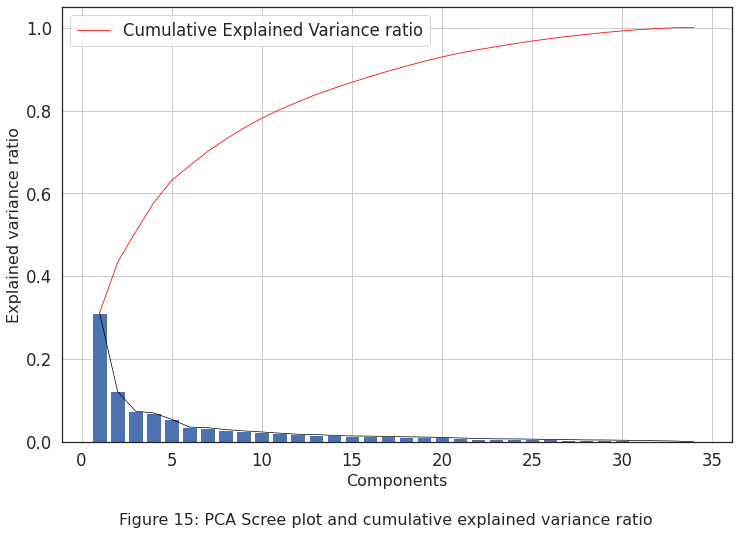

In [25]:
from sklearn.decomposition import PCA

pca = PCA(n_components= X_train_all.shape[1], random_state=rs)
X_train_tr = pca.fit_transform(X_train_all)

plt.figure(figsize = (12,8))
plt.bar(range(1,len(pca.explained_variance_ratio_ )+1),
         pca.explained_variance_ratio_, 
        )
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),
         pca.explained_variance_ratio_, 
         c = 'black',
         linewidth = 0.7
        )
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),
         np.cumsum(pca.explained_variance_ratio_),
         c='red',
         label="Cumulative Explained Variance ratio",
         linewidth = 0.8
        )


plt.ylabel('Explained variance ratio',fontdict= {"size":16})
plt.xlabel('Components',fontdict= {"size":16})
plt.legend(loc='upper left')
plt.figtext(0.5,-0.019, "Figure 15: PCA Scree plot and cumulative explained variance ratio", fontsize = 16, ha = 'center')
plt.grid(True)
plt.show()

cs = np.cumsum(pca.explained_variance_ratio_)
threshold = .90
mask = cs < threshold
n = sum(mask) + 1
pca_scores = {}
pca_gs_trained_models = {}

We replaced manual feature selection from our initial pipeline with PCA transformation Figure B. The classification results for all learning methods introduced in section 5 are reported in table 1.

<figure>
  <center>
      <img src="https://i.imgur.com/WaoC8Qr.png alt="Trulli" style="width:50%;height:50%">
  </center>
</figure>

<figure>
  <center>
      <img src="https://i.imgur.com/Y965fPl.png" alt="Trulli" style="width:50%;height:50%">
  </center>
</figure>

# 6. Conclusions
As we can see from Table 1, all the models have a pretty satisfying accuracy and f1-score. All models provide comparable results when we reduce the dimensionality using PCA. 
Logisitc regression benefits the most from PCA as data has lower dimensionality and all the features are uncorrelated. Decision trees provide excellent explainability but they have stability issues which we can overcome by using Random Forests. Support vector machine provides the best results in both with and without PCA cases. Since we are using RBG kernel in SVM, it has the lowest explainability among all other methods. 


<div class="alert alert-secondary " role="alert">
  <h1 class="alert-heading">7. References</h1>
    <hr>
    
1. Sigillito, V. G., Wing, S. P., Hutton, L. V., & Baker, K. B. (1989). Classification of radar returns from the ionosphere using neural networks. Johns Hopkins APL Technical Digest, 10, 262-266 
    <br>

2. Ionosphere dataset https://archive.ics.uci.edu/ml/datasets/ionosphere
    <br>

3. SMOTE: Synthetic Minority Over-sampling Technique (https://arxiv.org/pdf/1106.1813.pdf)
    <br>

4. Shai Ben-David Shai Shalev-Shwartz. UNDERSTANDING MACHINE LEARNING - From Theory to Algorithms. 1994.
    <br>

5. Dirk P. Kroese, Zdravko I. Botev, Thomas Taimre, Radislav Vaisman. Data Science and Machine Learning 2020
    <br>

6. Vijay Kotu, Bala Deshpande. Data Science: Concepts and Practice, Edition 2
    <br>
</div>